# Part 5: CIR

Under a no-arbitrage assumption, the Cox--Ingersoll--Ross model for the evolution of interest rates prices a bond as

$$P(r, t; a, b, \sigma) = A(t) \cdot \exp(-B(t) \cdot r)$$

with

$$h = \sqrt{a^2 + 2\sigma^2}$$

$$A(t) = \left[ \frac{2h \exp\left(\frac{(a + h)t}{2}\right)}{2h + (a + h)(\exp(ht) - 1)} \right]^{\frac{2ab}{\sigma^2}}$$

$$B(t) = \frac{2(\exp(ht) - 1)}{2h + (a + h)(\exp(ht) - 1)}$$

where:
- $r$ is the current short rate
- $t$ is the time to maturity (in years)
- $a, b, \sigma$ are positive model parameters

The continuously compounded rate of return (yield) is:

$$R_{\text{model}}(t; r, a, b, \sigma) = -\frac{1}{t} \log(P(r, t; a, b, \sigma)) \times 100\%$$

### Data

We are given observed US Treasury zero-coupon yields $R_{\text{data}}(w, t_j)$ for:
- $w = 1, \ldots, 9$ weeks (observation dates)
- $t_j \in \{1/12, 0.25, 0.5, 1, 3, 5, 7, 10, 20, 30\}$ years

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
print("Libraries imported successfully")

Libraries imported successfully


### Data Loading

The file `tbonds.txt` contains Treasury yield data with:
- Header line with maturities
- 9 rows of weekly data with dates and 10 yield values

In [2]:
# Define maturities
maturities = np.array([1/12, 0.25, 0.5, 1, 3, 5, 7, 10, 20, 30], dtype=float)
col_names = ["date"] + [str(m) for m in maturities]

# Read the Treasury bond data
tbonds = pd.read_csv(
    "tbonds.txt",
    sep='\s+',
    skiprows=1,
    header=None,
    names=col_names
)

# Remove any rows that are entirely NaN
tbonds = tbonds.dropna(how='all')

# Convert yield columns to float
for col in col_names[1:]:
    tbonds[col] = pd.to_numeric(tbonds[col], errors='coerce')

print("Data loaded successfully!")
print(f"Shape: {tbonds.shape}")
print(f"Expected: (9, 11)")
print(f"\nDates: {tbonds['date'].tolist()}")
print(f"\nData types:\n{tbonds.dtypes}")

Data loaded successfully!
Shape: (9, 11)
Expected: (9, 11)

Dates: ['09/12/24', '09/19/24', '09/26/24', '10/03/24', '10/10/24', '10/17/24', '10/24/24', '10/31/24', '11/07/24']

Data types:
date                    object
0.08333333333333333    float64
0.25                   float64
0.5                    float64
1.0                    float64
3.0                    float64
5.0                    float64
7.0                    float64
10.0                   float64
20.0                   float64
30.0                   float64
dtype: object


In [3]:
# Sanity check: display the data
print("Treasury Bond Yield Data (%):")
print(tbonds)
print(f"\nFirst row yields: {tbonds.iloc[0, 1:].values}")

Treasury Bond Yield Data (%):
       date  0.08333333333333333  0.25   0.5   1.0   3.0   5.0   7.0  10.0  \
0  09/12/24                 5.18  5.06  4.68  4.09  3.47  3.47  3.57  3.68   
1  09/19/24                 4.89  4.80  4.46  3.93  3.47  3.49  3.60  3.73   
2  09/26/24                 4.90  4.68  4.38  3.96  3.54  3.55  3.65  3.79   
3  10/03/24                 4.99  4.68  4.37  4.02  3.62  3.62  3.71  3.85   
4  10/10/24                 4.98  4.75  4.45  4.22  3.88  3.91  3.99  4.09   
5  10/17/24                 4.93  4.74  4.45  4.21  3.89  3.90  3.99  4.09   
6  10/24/24                 4.87  4.70  4.48  4.25  4.02  4.03  4.12  4.21   
7  10/31/24                 4.76  4.64  4.43  4.27  4.12  4.15  4.21  4.28   
8  11/07/24                 4.69  4.63  4.40  4.28  4.13  4.17  4.25  4.31   

   20.0  30.0  
0  4.07  4.00  
1  4.11  4.06  
2  4.17  4.12  
3  4.24  4.18  
4  4.44  4.38  
5  4.44  4.39  
6  4.54  4.47  
7  4.58  4.47  
8  4.62  4.52  

First row yields: [5.18 5.06

---

## 2. CIR Model Implementation

This section implements the CIR model functions for bond pricing and yield calculation.

In [4]:
def cir_h(a, sigma):
    """Compute h = sqrt(a^2 + 2*sigma^2)"""
    return np.sqrt(a**2 + 2*sigma**2)


def cir_A(t, a, b, sigma):
    """
    Compute A(t; a, b, sigma) for the CIR bond pricing formula.
    
    A(t) = [2h * exp((a+h)*t/2) / (2h + (a+h)*(exp(h*t)-1))]^(2ab/sigma^2)
    """
    h = cir_h(a, sigma)
    exp_ht = np.exp(np.clip(h * t, -700, 700))
    numerator = 2 * h * np.exp(np.clip((a + h) * t / 2, -700, 700))
    denom = 2 * h + (a + h) * (exp_ht - 1)
    denom = np.maximum(denom, 1e-12)  # Avoid division by zero
    
    C = numerator / denom
    C = np.clip(C, 1e-12, 1e12)
    
    if sigma > 1e-12:
        q = 2 * a * b / (sigma**2)
    else:
        q = 0.0
    
    exp_arg = np.clip(q * np.log(C), -700, 700)
    return np.exp(exp_arg)


def cir_B(t, a, sigma):
    """
    Compute B(t; a, sigma) for the CIR bond pricing formula.
    
    B(t) = 2*(exp(h*t) - 1) / (2h + (a+h)*(exp(h*t) - 1))
    """
    h = cir_h(a, sigma)
    exp_ht = np.exp(np.clip(h * t, -700, 700))
    denom = 2 * h + (a + h) * (exp_ht - 1)
    denom = np.maximum(denom, 1e-12)
    return 2 * (exp_ht - 1) / denom


def bond_price(r, t, a, b, sigma):
    """
    CIR zero-coupon bond price: P(r, t; a, b, sigma) = A(t) * exp(-B(t) * r)
    """
    A = cir_A(t, a, b, sigma)
    B = cir_B(t, a, sigma)
    P = A * np.exp(-B * r)
    return np.maximum(P, 1e-12)


def yield_cir(r, t, a, b, sigma):
    """
    Continuously compounded yield (in percent):
    R_model(t; r, a, b, sigma) = -(1/t) * log(P(r, t; a, b, sigma)) * 100
    """
    P = bond_price(r, t, a, b, sigma)
    t_safe = np.maximum(t, 1e-8)
    return -(np.log(P) / t_safe) * 100.0


def get_week_yields(tbonds, w_idx, maturities):
    """
    Extract yields for a given week index.
    
    Returns:
        t_vec: maturities array
        y_data_vec: observed yields for that week
    """
    mat_cols = [str(m) for m in maturities]
    y_data_vec = tbonds.iloc[w_idx][mat_cols].values.astype(float)
    return maturities.copy(), y_data_vec


print("CIR model functions defined successfully")

CIR model functions defined successfully


---

## 3. Nonlinear Least Squares Formulation

### Parameter Transformation

To enforce positivity of parameters $(r, a, b, \sigma)$, we use a log-transformation:

$$\tilde{\theta} = [\log(r), \log(a), \log(b), \log(\sigma)] \in \mathbb{R}^4$$

So the unconstrained optimization is performed over $\tilde{\theta}$ and parameters are recovered via $\theta = \exp(\tilde{\theta})$.

### Weekly Least Squares

For a given week $w$ and parameter vector $\tilde{\theta}$, the residual vector $F_{\text{week}}(\tilde{\theta}) \in \mathbb{R}^{10}$ has components:

$$F_{\text{week},j}(\tilde{\theta}) = R_{\text{model}}(t_j; r, a, b, \sigma) - R_{\text{data}}(w, t_j)$$

The least-squares objective is:

$$f_{\text{week}}(\tilde{\theta}) = \|F_{\text{week}}(\tilde{\theta})\|_2^2$$

In [5]:
# Parameter encoding/decoding for positivity constraints
def decode_params_week(theta_tilde):
    """
    Decode transformed parameters to original (positive) parameters.
    theta_tilde = [log(r), log(a), log(b), log(sigma)]
    Returns: [r, a, b, sigma] (all positive)
    """
    return np.exp(theta_tilde)


def encode_params_week(params):
    """
    Encode parameters to transformed (unconstrained) space.
    params = [r, a, b, sigma]
    Returns: theta_tilde = [log(r), log(a), log(b), log(sigma)]
    """
    return np.log(np.maximum(params, 1e-10))


def residuals_week_transformed(theta_tilde, t_vec, R_data):
    """
    Compute residual vector F_week(theta_tilde) for one week.
    Uses log-transform: params = exp(theta_tilde)
    """
    params = decode_params_week(theta_tilde)
    r, a, b, sigma = params
    
    R_model = np.array([yield_cir(r, t, a, b, sigma) for t in t_vec])
    return R_model - R_data


def objective_week_transformed(theta_tilde, t_vec, R_data):
    """
    Least-squares objective for one week: f_week(theta_tilde) = ||F_week(theta_tilde)||^2
    """
    F = residuals_week_transformed(theta_tilde, t_vec, R_data)
    return np.dot(F, F)


print("Weekly least-squares formulation defined")

Weekly least-squares formulation defined


### Panel Least Squares (Part 2)

For panel calibration, we have common parameters $(a, b, \sigma)$ across all weeks, with week-specific short rates $r_w$:

$$\tilde{\theta}_{\text{panel}} = [\log(a), \log(b), \log(\sigma), \log(r_1), \ldots, \log(r_9)] \in \mathbb{R}^{12}$$

The panel residual vector $F_{\text{panel}}(\tilde{\theta}) \in \mathbb{R}^{90}$ stacks all week-maturity residuals.

In [6]:
def decode_params_panel(theta_tilde, n_weeks):
    """
    Decode panel parameters.
    theta_tilde = [log(a), log(b), log(sigma), log(r_1), ..., log(r_n_weeks)]
    Returns: a, b, sigma, r_array
    """
    a = np.exp(theta_tilde[0])
    b = np.exp(theta_tilde[1])
    sigma = np.exp(theta_tilde[2])
    r_array = np.exp(theta_tilde[3:3+n_weeks])
    return a, b, sigma, r_array


def residuals_panel_transformed(theta_tilde, tbonds, maturities):
    """
    Compute residual vector F_panel(theta_tilde) for all weeks.
    Returns: residual vector of length n_weeks * n_maturities
    """
    n_weeks = len(tbonds)
    a, b, sigma, r_array = decode_params_panel(theta_tilde, n_weeks)
    
    residuals = []
    mat_cols = [str(m) for m in maturities]
    
    for w in range(n_weeks):
        r_w = r_array[w]
        R_data_w = tbonds.iloc[w][mat_cols].values.astype(float)
        
        for j, t_j in enumerate(maturities):
            R_model_j = yield_cir(r_w, t_j, a, b, sigma)
            residuals.append(R_model_j - R_data_w[j])
    
    return np.array(residuals)


def objective_panel_transformed(theta_tilde, tbonds, maturities):
    """Panel least-squares objective: f_panel(theta_tilde) = ||F_panel(theta_tilde)||^2"""
    F = residuals_panel_transformed(theta_tilde, tbonds, maturities)
    return np.dot(F, F)


print("Panel least-squares formulation defined")

Panel least-squares formulation defined


---

## 4. Optimization Algorithms

This section implements three optimization algorithms:
1. **Steepest Descent (Gradient Descent)** with Armijo line search
2. **Newton's Method** with damped line search
3. **Gauss-Newton Method** for nonlinear least squares

All methods use backtracking line search satisfying the Armijo (sufficient decrease) condition.

### 4.1 Common Infrastructure: Numerical Derivatives and Line Search

In [7]:
def numerical_grad(f, x, eps=1e-6):
    """
    Compute gradient of f at x using central differences.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    grad = np.zeros(n)
    
    for i in range(n):
        x_plus = x.copy()
        x_minus = x.copy()
        h = eps * max(1.0, abs(x[i]))
        x_plus[i] += h
        x_minus[i] -= h
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * h)
    
    return grad


def numerical_hessian(f, x, eps=1e-4):
    """
    Compute Hessian of f at x using finite differences.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    H = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            h_i = eps * max(1.0, abs(x[i]))
            h_j = eps * max(1.0, abs(x[j]))
            
            x_pp = x.copy(); x_pp[i] += h_i; x_pp[j] += h_j
            x_pm = x.copy(); x_pm[i] += h_i; x_pm[j] -= h_j
            x_mp = x.copy(); x_mp[i] -= h_i; x_mp[j] += h_j
            x_mm = x.copy(); x_mm[i] -= h_i; x_mm[j] -= h_j
            
            H[i, j] = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4 * h_i * h_j)
    
    return H


def numerical_jacobian(F, x, eps=1e-6):
    """
    Compute Jacobian of F: R^n -> R^m at x using forward differences.
    Returns: m x n Jacobian matrix
    """
    x = np.asarray(x, dtype=float)
    F0 = F(x)
    m = len(F0)
    n = len(x)
    J = np.zeros((m, n))
    
    for k in range(n):
        x_pert = x.copy()
        h = eps * max(1.0, abs(x[k]))
        x_pert[k] += h
        Fk = F(x_pert)
        J[:, k] = (Fk - F0) / h
    
    return J


print("Numerical derivative functions defined")

Numerical derivative functions defined


In [8]:
def backtracking_line_search(f, x, p, grad, alpha0=1.0, rho=0.5, c1=1e-4, max_iter=50):
    """
    Backtracking line search with Armijo condition.
    
    Find alpha > 0 such that:
        f(x + alpha*p) <= f(x) + c1*alpha*grad^T*p
    
    Args:
        f: objective function
        x: current point
        p: search direction
        grad: gradient at x
        alpha0: initial step size
        rho: contraction factor in (0, 1)
        c1: Armijo constant in (0, 1)
        max_iter: maximum backtracking iterations
        
    Returns:
        alpha: step size satisfying Armijo condition
    """
    alpha = alpha0
    f_x = f(x)
    grad_p = np.dot(grad, p)
    
    # Ensure we have a descent direction
    if grad_p >= 0:
        return 0.0
    
    for _ in range(max_iter):
        x_new = x + alpha * p
        if f(x_new) <= f_x + c1 * alpha * grad_p:
            return alpha
        alpha *= rho
    
    return alpha


print("Backtracking line search defined")

Backtracking line search defined


### 4.2 Steepest Descent (Gradient Descent)

The steepest descent algorithm uses the negative gradient as the search direction:

$$p_k = -\nabla f(x_k)$$

Then applies backtracking line search to find step size $\alpha_k$.

In [9]:
def steepest_descent(f, x0, tol=1e-6, maxit=200, verbose=False):
    """
    Steepest descent (gradient descent) with backtracking line search.
    
    Args:
        f: objective function R^n -> R
        x0: initial point
        tol: convergence tolerance on gradient norm
        maxit: maximum iterations
        verbose: print progress
        
    Returns:
        x: final solution
        f_val: final objective value
        history: dict with iteration history
    """
    x = np.asarray(x0, dtype=float).copy()
    history = {'f_vals': [], 'grad_norms': [], 'step_sizes': []}
    
    for k in range(maxit):
        f_val = f(x)
        g = numerical_grad(f, x)
        ng = np.linalg.norm(g)
        
        history['f_vals'].append(f_val)
        history['grad_norms'].append(ng)
        
        if verbose and k % 20 == 0:
            print(f"[SD] iter {k:4d}, f={f_val:.6e}, ||grad||={ng:.6e}")
        
        if ng <= tol:
            if verbose:
                print(f"[SD] Converged at iteration {k}")
            break
        
        p = -g  # steepest descent direction
        
        alpha = backtracking_line_search(f, x, p, g)
        if alpha < 1e-12:
            if verbose:
                print(f"[SD] Line search failed at iteration {k}")
            break
            
        history['step_sizes'].append(alpha)
        x = x + alpha * p
    
    return x, f(x), history


print("Steepest descent algorithm defined")

Steepest descent algorithm defined


### 4.3 Newton's Method

Newton's method uses the Hessian to compute the search direction:

$$H_k p_k = -\nabla f(x_k)$$

where $H_k = \nabla^2 f(x_k)$. We use damped Newton (with line search) for robustness.

If the Hessian is not positive definite, we add regularization or fall back to gradient descent.

In [10]:
def newton_method(f, x0, tol=1e-6, maxit=50, damping=True, verbose=False):
    """
    Newton's method for unconstrained optimization with optional line search.
    
    Args:
        f: objective function R^n -> R
        x0: initial point
        tol: convergence tolerance on gradient norm
        maxit: maximum iterations
        damping: whether to use line search
        verbose: print progress
        
    Returns:
        x: final solution
        f_val: final objective value
        history: dict with iteration history
    """
    x = np.asarray(x0, dtype=float).copy()
    n = len(x)
    history = {'f_vals': [], 'grad_norms': [], 'step_sizes': []}
    
    for k in range(maxit):
        f_val = f(x)
        g = numerical_grad(f, x)
        ng = np.linalg.norm(g)
        
        history['f_vals'].append(f_val)
        history['grad_norms'].append(ng)
        
        if verbose and k % 10 == 0:
            print(f"[Newton] iter {k:4d}, f={f_val:.6e}, ||grad||={ng:.6e}")
        
        if ng <= tol:
            if verbose:
                print(f"[Newton] Converged at iteration {k}")
            break
        
        H = numerical_hessian(f, x)
        
        # Try to solve H*p = -g with regularization if needed
        reg = 1e-8
        for attempt in range(10):
            try:
                H_reg = H + reg * np.eye(n)
                # Check positive definiteness
                np.linalg.cholesky(H_reg)
                p = np.linalg.solve(H_reg, -g)
                break
            except np.linalg.LinAlgError:
                reg *= 10
        else:
            # Fallback to steepest descent
            p = -g
        
        # Check if p is a descent direction
        if np.dot(g, p) >= 0:
            p = -g  # fallback to gradient descent
        
        if damping:
            alpha = backtracking_line_search(f, x, p, g)
        else:
            alpha = 1.0
        
        if alpha < 1e-12:
            if verbose:
                print(f"[Newton] Line search failed at iteration {k}")
            break
            
        history['step_sizes'].append(alpha)
        x = x + alpha * p
    
    return x, f(x), history


print("Newton's method defined")

Newton's method defined


### 4.4 Gauss-Newton Method

For nonlinear least squares $\min_x \|F(x)\|^2$, Gauss-Newton uses the approximation:

$$\nabla^2 f(x) \approx 2 J_F(x)^T J_F(x)$$

The Gauss-Newton step solves:

$$(J^T J) p = -J^T F$$

This avoids computing second derivatives of $F$ and is well-suited for least-squares problems.

In [11]:
def gauss_newton(F, x0, tol=1e-6, maxit=50, verbose=False):
    """
    Gauss-Newton method for nonlinear least squares: min ||F(x)||^2.
    
    Uses the approximation: Hessian approx 2*J^T*J
    
    Args:
        F: residual function R^n -> R^m
        x0: initial point
        tol: convergence tolerance on gradient norm
        maxit: maximum iterations
        verbose: print progress
        
    Returns:
        x: final solution
        f_val: final objective value ||F(x)||^2
        history: dict with iteration history
    """
    x = np.asarray(x0, dtype=float).copy()
    n = len(x)
    history = {'f_vals': [], 'grad_norms': [], 'step_sizes': []}
    
    # Define scalar objective
    def f_scalar(z):
        r = F(z)
        return np.dot(r, r)
    
    for k in range(maxit):
        r = F(x)
        f_val = np.dot(r, r)
        
        J = numerical_jacobian(F, x)
        g = 2 * J.T @ r  # gradient of ||F(x)||^2
        ng = np.linalg.norm(g)
        
        history['f_vals'].append(f_val)
        history['grad_norms'].append(ng)
        
        if verbose and k % 10 == 0:
            print(f"[GN] iter {k:4d}, f={f_val:.6e}, ||J^T r||={ng:.6e}")
        
        if ng <= tol:
            if verbose:
                print(f"[GN] Converged at iteration {k}")
            break
        
        # Gauss-Newton Hessian approximation: H_gn = 2 * J^T @ J
        H_gn = 2 * (J.T @ J)
        
        # Solve with regularization if needed
        reg = 1e-8
        for attempt in range(10):
            try:
                p = np.linalg.solve(H_gn + reg * np.eye(n), -g)
                break
            except np.linalg.LinAlgError:
                reg *= 10
        else:
            p = -g  # fallback
        
        # Check descent direction
        if np.dot(g, p) >= 0:
            p = -g
        
        # Line search
        alpha = backtracking_line_search(f_scalar, x, p, g)
        if alpha < 1e-12:
            if verbose:
                print(f"[GN] Line search failed at iteration {k}")
            break
            
        history['step_sizes'].append(alpha)
        x = x + alpha * p
    
    return x, f_scalar(x), history


print("Gauss-Newton method defined")

Gauss-Newton method defined


---

## 5. Part (1): Week-by-Week Parameter Fitting

For each week $w$ independently, we find parameters $(r_w, a_w, b_w, \sigma_w)$ that minimize the sum of squared yield errors across the 10 maturities.

In [12]:
def make_week_objective(tbonds, w_idx, maturities):
    """
    Create objective and residual functions for a single week.
    
    Returns:
        f_week: scalar objective function
        F_week: residual vector function
        t_vec: maturities
        R_data: observed yields
    """
    t_vec, R_data = get_week_yields(tbonds, w_idx, maturities)
    
    def F_week(theta_tilde):
        return residuals_week_transformed(theta_tilde, t_vec, R_data)
    
    def f_week(theta_tilde):
        return objective_week_transformed(theta_tilde, t_vec, R_data)
    
    return f_week, F_week, t_vec, R_data


def compute_rmse(residuals):
    """Compute RMSE from residuals."""
    return np.sqrt(np.mean(residuals**2))


print("Week objective functions defined")

Week objective functions defined


### 5.1 Algorithm Comparison on Test Week

We first compare all three methods on week 0 to understand their convergence behavior.

In [13]:
# Test all three methods on Week 0
w_test = 0
f_week, F_week, t_vec, R_data = make_week_objective(tbonds, w_test, maturities)

# Initial guess
r0, a0, b0, sigma0 = 0.04, 0.5, 0.05, 0.05
theta0 = encode_params_week([r0, a0, b0, sigma0])

print(f"Testing on Week {w_test} ({tbonds.iloc[w_test]['date']})")
print(f"Initial parameters: r={r0}, a={a0}, b={b0}, sigma={sigma0}")
print(f"Initial theta_tilde: {theta0}")
print(f"Initial objective: {f_week(theta0):.6f}")
print()

# Run each method
results_test = {}

print("=" * 60)
print("STEEPEST DESCENT")
print("=" * 60)
x_sd, f_sd, hist_sd = steepest_descent(f_week, theta0, tol=1e-6, maxit=300, verbose=True)
params_sd = decode_params_week(x_sd)
rmse_sd = compute_rmse(F_week(x_sd))
results_test['Steepest Descent'] = {'params': params_sd, 'f_val': f_sd, 'rmse': rmse_sd, 'history': hist_sd}
print(f"\nFinal params: r={params_sd[0]:.6f}, a={params_sd[1]:.6f}, b={params_sd[2]:.6f}, sigma={params_sd[3]:.6f}")
print(f"Final objective: {f_sd:.6f}, RMSE: {rmse_sd:.6f}")
print(f"Iterations: {len(hist_sd['f_vals'])}")

Testing on Week 0 (09/12/24)
Initial parameters: r=0.04, a=0.5, b=0.05, sigma=0.05
Initial theta_tilde: [-3.21887582 -0.69314718 -2.99573227 -2.99573227]
Initial objective: 9.023639

STEEPEST DESCENT
[SD] iter    0, f=9.023639e+00, ||grad||=4.427869e+01
[SD] iter   20, f=1.540490e+00, ||grad||=1.475891e+00
[SD] iter   40, f=1.345391e+00, ||grad||=1.115625e+00
[SD] iter   60, f=1.160696e+00, ||grad||=1.218582e+00
[SD] iter   80, f=1.008361e+00, ||grad||=8.194134e-01
[SD] iter  100, f=8.837449e-01, ||grad||=2.091519e+00
[SD] iter  120, f=7.912520e-01, ||grad||=1.104761e+00
[SD] iter  140, f=7.232669e-01, ||grad||=1.047173e+00
[SD] iter  160, f=6.748718e-01, ||grad||=5.943547e-01
[SD] iter  180, f=6.418695e-01, ||grad||=1.016368e+00
[SD] iter  200, f=6.168151e-01, ||grad||=3.833824e-01
[SD] iter  220, f=6.010083e-01, ||grad||=2.873861e-01
[SD] iter  240, f=5.898368e-01, ||grad||=2.617907e-01
[SD] iter  260, f=5.819693e-01, ||grad||=2.801639e-01
[SD] iter  280, f=5.765981e-01, ||grad||=3.9

In [14]:
print()
print("=" * 60)
print("NEWTON'S METHOD")
print("=" * 60)
x_nt, f_nt, hist_nt = newton_method(f_week, theta0, tol=1e-8, maxit=100, damping=True, verbose=True)
params_nt = decode_params_week(x_nt)
rmse_nt = compute_rmse(F_week(x_nt))
results_test['Newton'] = {'params': params_nt, 'f_val': f_nt, 'rmse': rmse_nt, 'history': hist_nt}
print(f"\nFinal params: r={params_nt[0]:.6f}, a={params_nt[1]:.6f}, b={params_nt[2]:.6f}, sigma={params_nt[3]:.6f}")
print(f"Final objective: {f_nt:.6f}, RMSE: {rmse_nt:.6f}")
print(f"Iterations: {len(hist_nt['f_vals'])}")


NEWTON'S METHOD
[Newton] iter    0, f=9.023639e+00, ||grad||=4.427869e+01
[Newton] iter   10, f=5.615611e-01, ||grad||=2.828661e-01
[Newton] iter   20, f=5.326744e-01, ||grad||=8.854903e-01
[Newton] iter   30, f=5.305293e-01, ||grad||=5.049712e-02
[Newton] iter   40, f=5.305227e-01, ||grad||=5.027943e-02
[Newton] iter   50, f=5.305134e-01, ||grad||=5.029082e-02
[Newton] iter   60, f=5.305111e-01, ||grad||=1.535877e+00
[Newton] Line search failed at iteration 62

Final params: r=0.053800, a=3.182638, b=0.047172, sigma=2.761795
Final objective: 0.530511, RMSE: 0.230328
Iterations: 63


In [15]:
print()
print("=" * 60)
print("GAUSS-NEWTON")
print("=" * 60)
x_gn, f_gn, hist_gn = gauss_newton(F_week, theta0, tol=1e-8, maxit=100, verbose=True)
params_gn = decode_params_week(x_gn)
rmse_gn = compute_rmse(F_week(x_gn))
results_test['Gauss-Newton'] = {'params': params_gn, 'f_val': f_gn, 'rmse': rmse_gn, 'history': hist_gn}
print(f"\nFinal params: r={params_gn[0]:.6f}, a={params_gn[1]:.6f}, b={params_gn[2]:.6f}, sigma={params_gn[3]:.6f}")
print(f"Final objective: {f_gn:.6f}, RMSE: {rmse_gn:.6f}")
print(f"Iterations: {len(hist_gn['f_vals'])}")


GAUSS-NEWTON
[GN] iter    0, f=9.023639e+00, ||J^T r||=4.427875e+01
[GN] Line search failed at iteration 8

Final params: r=0.047421, a=0.549670, b=0.034743, sigma=0.000003
Final objective: 1.581455, RMSE: 0.397675
Iterations: 9


### 5.2 Convergence Plots

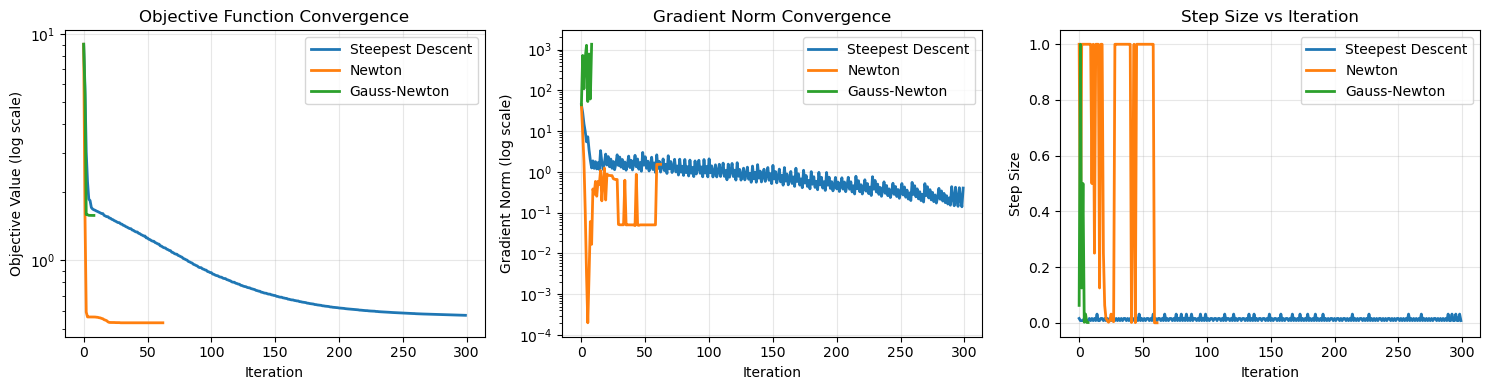

Convergence plots saved to 'convergence_comparison.png'


In [16]:
# Plot convergence curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Objective value convergence
ax1 = axes[0]
for name, res in results_test.items():
    ax1.semilogy(res['history']['f_vals'], label=name, linewidth=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective Value (log scale)')
ax1.set_title('Objective Function Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gradient norm convergence
ax2 = axes[1]
for name, res in results_test.items():
    ax2.semilogy(res['history']['grad_norms'], label=name, linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Gradient Norm (log scale)')
ax2.set_title('Gradient Norm Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Step sizes
ax3 = axes[2]
for name, res in results_test.items():
    if res['history']['step_sizes']:
        ax3.plot(res['history']['step_sizes'], label=name, linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Step Size')
ax3.set_title('Step Size vs Iteration')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Convergence plots saved to 'convergence_comparison.png'")

### 5.3 Fit All 9 Weeks

Using Gauss-Newton (typically best for nonlinear least squares), we calibrate each week independently.

In [17]:
# Fit all 9 weeks using Gauss-Newton
n_weeks = len(tbonds)
part1_results = []

print("=" * 70)
print("PART 1: Week-by-Week Calibration with Gauss-Newton")
print("=" * 70)

for w in range(n_weeks):
    f_week, F_week, t_vec, R_data = make_week_objective(tbonds, w, maturities)
    
    # Initial guess
    theta0 = encode_params_week([0.04, 0.5, 0.05, 0.05])
    
    # Run Gauss-Newton
    x_opt, f_opt, history = gauss_newton(F_week, theta0, tol=1e-8, maxit=100, verbose=False)
    
    params = decode_params_week(x_opt)
    residuals = F_week(x_opt)
    rmse = compute_rmse(residuals)
    
    result = {
        'week': w,
        'date': tbonds.iloc[w]['date'],
        'r': params[0],
        'a': params[1],
        'b': params[2],
        'sigma': params[3],
        'SSE': f_opt,
        'RMSE': rmse,
        'iterations': len(history['f_vals'])
    }
    part1_results.append(result)
    
    print(f"Week {w} ({result['date']}): r={params[0]:.6f}, a={params[1]:.6f}, "
          f"b={params[2]:.6f}, sigma={params[3]:.6f}, RMSE={rmse:.4f}")

# Create summary DataFrame
part1_df = pd.DataFrame(part1_results)
print("\n" + "=" * 70)
print("Part 1 Summary Table")
print("=" * 70)
print(part1_df.to_string(index=False))

# Overall RMSE for Part 1
all_residuals_part1 = []
for w in range(n_weeks):
    f_week, F_week, t_vec, R_data = make_week_objective(tbonds, w, maturities)
    theta_opt = encode_params_week([part1_results[w]['r'], part1_results[w]['a'],
                                    part1_results[w]['b'], part1_results[w]['sigma']])
    all_residuals_part1.extend(F_week(theta_opt))

overall_rmse_part1 = compute_rmse(np.array(all_residuals_part1))
print(f"\nOverall RMSE (Part 1): {overall_rmse_part1:.6f}")

PART 1: Week-by-Week Calibration with Gauss-Newton
Week 0 (09/12/24): r=0.047421, a=0.549670, b=0.034743, sigma=0.000003, RMSE=0.3977
Week 1 (09/19/24): r=0.044275, a=0.551077, b=0.037215, sigma=0.000005, RMSE=0.3750
Week 2 (09/26/24): r=0.044427, a=0.502398, b=0.036933, sigma=0.000006, RMSE=0.3525
Week 3 (10/03/24): r=0.044675, a=0.581453, b=0.036260, sigma=0.000002, RMSE=0.3516
Week 4 (10/10/24): r=0.045256, a=0.626216, b=0.040088, sigma=0.000008, RMSE=0.2833
Week 5 (10/17/24): r=0.044212, a=0.579095, b=0.042409, sigma=0.000000, RMSE=0.2951
Week 6 (10/24/24): r=0.043624, a=0.573496, b=0.043239, sigma=0.000000, RMSE=0.2289
Week 7 (10/31/24): r=0.043813, a=0.612981, b=0.042866, sigma=0.000000, RMSE=0.1773
Week 8 (11/07/24): r=0.043959, a=0.552033, b=0.043488, sigma=0.000006, RMSE=0.1910

Part 1 Summary Table
 week     date        r        a        b        sigma      SSE     RMSE  iterations
    0 09/12/24 0.047421 0.549670 0.034743 2.629714e-06 1.581455 0.397675           9
    1 09/1

### 5.4 Fitted vs Observed Yields

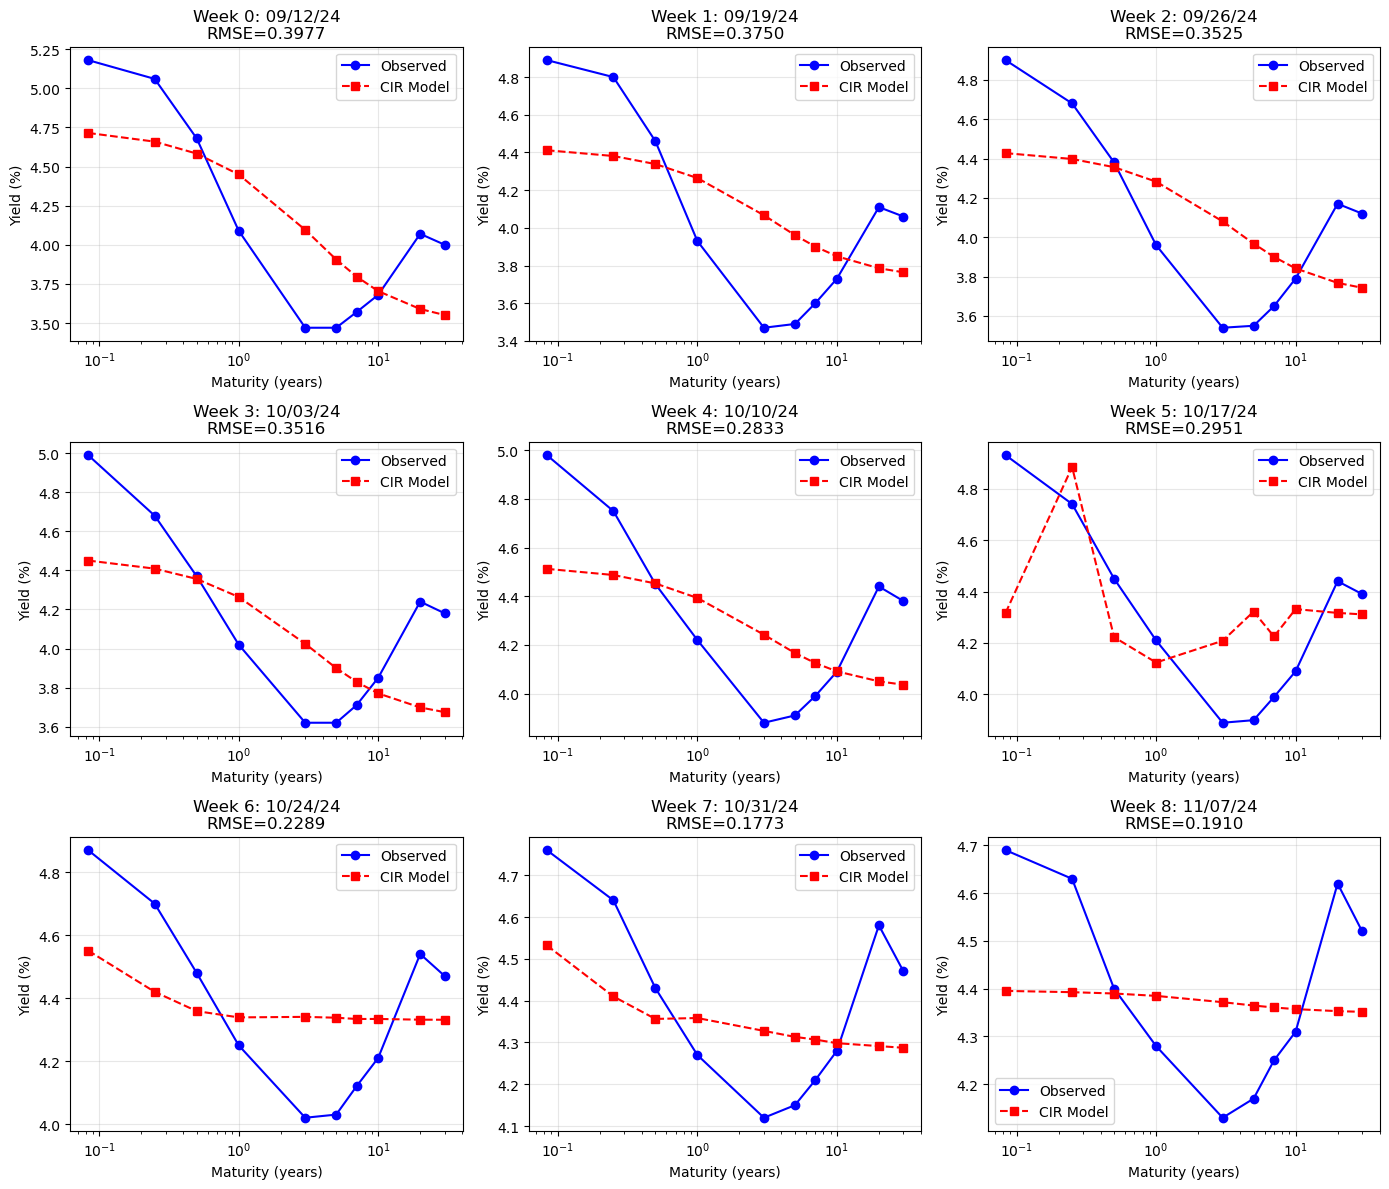

Part 1 fits saved to 'part1_fits.png'


In [18]:
# Plot fitted vs observed yields for selected weeks
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for w in range(n_weeks):
    ax = axes[w]
    
    # Get observed yields
    _, R_data = get_week_yields(tbonds, w, maturities)
    
    # Get fitted yields
    r, a, b, sigma = part1_results[w]['r'], part1_results[w]['a'], part1_results[w]['b'], part1_results[w]['sigma']
    R_fitted = np.array([yield_cir(r, t, a, b, sigma) for t in maturities])
    
    ax.plot(maturities, R_data, 'bo-', label='Observed', markersize=6)
    ax.plot(maturities, R_fitted, 'rs--', label='CIR Model', markersize=6)
    ax.set_xlabel('Maturity (years)')
    ax.set_ylabel('Yield (%)')
    ax.set_title(f"Week {w}: {part1_results[w]['date']}\nRMSE={part1_results[w]['RMSE']:.4f}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.savefig('part1_fits.png', dpi=150, bbox_inches='tight')
plt.show()

print("Part 1 fits saved to 'part1_fits.png'")

### 5.5 Algorithm Comparison Discussion

**Steepest Descent (Gradient Descent):**
- Uses only first-order information (gradient)
- Linear convergence rate
- Can "zig-zag" in narrow valleys due to orthogonal search directions
- Most robust to poor initial guesses but slowest to converge

**Newton's Method:**
- Uses second-order information (Hessian)
- Quadratic convergence near optimum
- Sensitive to Hessian conditioning; may require regularization
- Full Hessian computation can be expensive for large problems

**Gauss-Newton:**
- Specialized for nonlinear least squares problems
- Approximates Hessian as $J^T J$ (avoids second derivatives of residuals)
- Often achieves near-quadratic convergence for well-posed problems
- Best choice for calibration problems like this one

---

## 6. Part (2): Panel Calibration with Common $(a, b, \sigma)$

In this section, we fit a single set of $(a, b, \sigma)$ across all 9 weeks, while allowing each week to have its own short rate $r_w$.

This is a more parsimonious model: instead of $9 \times 4 = 36$ parameters, we have $3 + 9 = 12$ parameters.

In [19]:
def make_panel_objective(tbonds, maturities):
    """
    Create objective and residual functions for panel calibration.
    """
    def F_panel(theta_tilde):
        return residuals_panel_transformed(theta_tilde, tbonds, maturities)
    
    def f_panel(theta_tilde):
        return objective_panel_transformed(theta_tilde, tbonds, maturities)
    
    return f_panel, F_panel


# Initialize from Part 1 results
a0_panel = np.median([r['a'] for r in part1_results])
b0_panel = np.median([r['b'] for r in part1_results])
sigma0_panel = np.median([r['sigma'] for r in part1_results])
r0_panel = np.array([r['r'] for r in part1_results])

print("Initial panel parameters from Part 1 medians:")
print(f"  a = {a0_panel:.6f}")
print(f"  b = {b0_panel:.6f}")
print(f"  sigma = {sigma0_panel:.6f}")
print(f"  r_w = {r0_panel}")

theta0_panel = np.concatenate([
    np.log([a0_panel, b0_panel, sigma0_panel]),
    np.log(r0_panel)
])

print(f"\nInitial theta_panel shape: {theta0_panel.shape}")

Initial panel parameters from Part 1 medians:
  a = 0.573496
  b = 0.040088
  sigma = 0.000003
  r_w = [0.04742145 0.04427487 0.04442714 0.04467509 0.04525635 0.04421231
 0.04362405 0.04381291 0.04395899]

Initial theta_panel shape: (12,)


In [20]:
# Fit panel model using Gauss-Newton
f_panel, F_panel = make_panel_objective(tbonds, maturities)

print("=" * 70)
print("PART 2: Panel Calibration with Gauss-Newton")
print("=" * 70)

print(f"Initial panel objective: {f_panel(theta0_panel):.6f}")

x_panel, f_panel_opt, hist_panel = gauss_newton(F_panel, theta0_panel, tol=1e-8, maxit=200, verbose=True)

# Decode results
a_panel, b_panel, sigma_panel, r_panel = decode_params_panel(x_panel, n_weeks)

print("\n" + "=" * 70)
print("Panel Calibration Results")
print("=" * 70)
print(f"Common parameters:")
print(f"  a     = {a_panel:.6f}")
print(f"  b     = {b_panel:.6f}")
print(f"  sigma = {sigma_panel:.6f}")
print(f"\nWeek-specific short rates:")
for w in range(n_weeks):
    print(f"  Week {w} ({tbonds.iloc[w]['date']}): r_{w} = {r_panel[w]:.6f}")

# Compute overall and per-week RMSE
panel_residuals = F_panel(x_panel)
overall_rmse_panel = compute_rmse(panel_residuals)

# Per-week RMSE for Part 2
part2_week_rmse = []
mat_cols = [str(m) for m in maturities]
for w in range(n_weeks):
    R_data_w = tbonds.iloc[w][mat_cols].values.astype(float)
    R_fitted_w = np.array([yield_cir(r_panel[w], t, a_panel, b_panel, sigma_panel) for t in maturities])
    week_residuals = R_fitted_w - R_data_w
    part2_week_rmse.append(compute_rmse(week_residuals))

print(f"\nOverall RMSE (Part 2): {overall_rmse_panel:.6f}")

PART 2: Panel Calibration with Gauss-Newton
Initial panel objective: 11.670953
[GN] iter    0, f=1.167095e+01, ||J^T r||=1.559753e+04
[GN] Line search failed at iteration 2

Panel Calibration Results
Common parameters:
  a     = 0.573497
  b     = 0.040093
  sigma = 0.000003

Week-specific short rates:
  Week 0 (09/12/24): r_0 = 0.047379
  Week 1 (09/19/24): r_1 = 0.044239
  Week 2 (09/26/24): r_2 = 0.044389
  Week 3 (10/03/24): r_3 = 0.044640
  Week 4 (10/10/24): r_4 = 0.045230
  Week 5 (10/17/24): r_5 = 0.044193
  Week 6 (10/24/24): r_6 = 0.043612
  Week 7 (10/31/24): r_7 = 0.043798
  Week 8 (11/07/24): r_8 = 0.043942

Overall RMSE (Part 2): 0.359939


### 6.1 Model Comparison

In [21]:
# Create comparison table
comparison_data = []
for w in range(n_weeks):
    comparison_data.append({
        'Week': w,
        'Date': tbonds.iloc[w]['date'],
        'RMSE_Part1': part1_results[w]['RMSE'],
        'RMSE_Part2': part2_week_rmse[w],
        'Delta': part2_week_rmse[w] - part1_results[w]['RMSE']
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 70)
print("MODEL COMPARISON: Part 1 vs Part 2")
print("=" * 70)
print(comparison_df.to_string(index=False))
print()
print(f"Overall RMSE - Part 1 (week-specific params): {overall_rmse_part1:.6f}")
print(f"Overall RMSE - Part 2 (common a,b,sigma):     {overall_rmse_panel:.6f}")
print(f"Difference (Part 2 - Part 1):                 {overall_rmse_panel - overall_rmse_part1:.6f}")
print()
print(f"Part 1 uses {n_weeks * 4} = 36 parameters")
print(f"Part 2 uses 3 + {n_weeks} = {3 + n_weeks} parameters")

MODEL COMPARISON: Part 1 vs Part 2
 Week     Date  RMSE_Part1  RMSE_Part2     Delta
    0 09/12/24    0.397675    0.505857  0.108182
    1 09/19/24    0.375013    0.437599  0.062587
    2 09/26/24    0.352547    0.396895  0.044348
    3 10/03/24    0.351557    0.374387  0.022830
    4 10/10/24    0.283323    0.286039  0.002717
    5 10/17/24    0.295127    0.294423 -0.000705
    6 10/24/24    0.228896    0.303817  0.074921
    7 10/31/24    0.177282    0.279991  0.102709
    8 11/07/24    0.190978    0.285877  0.094900

Overall RMSE - Part 1 (week-specific params): 0.304472
Overall RMSE - Part 2 (common a,b,sigma):     0.359939
Difference (Part 2 - Part 1):                 0.055467

Part 1 uses 36 = 36 parameters
Part 2 uses 3 + 9 = 12 parameters


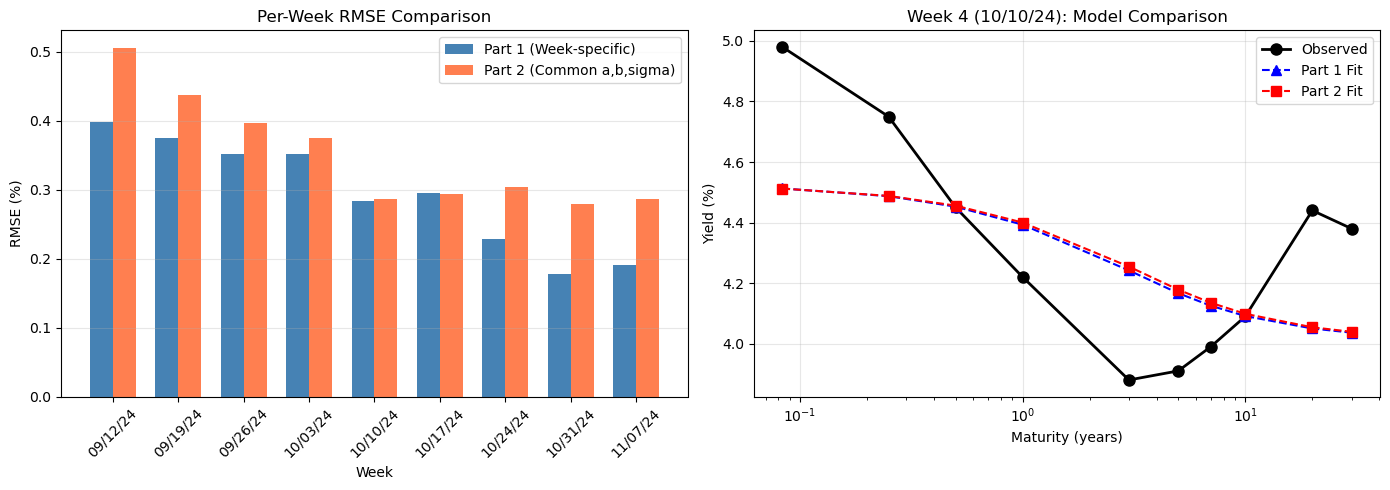

Model comparison plot saved to 'model_comparison.png'


In [22]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Per-week RMSE comparison
ax1 = axes[0]
x_pos = np.arange(n_weeks)
width = 0.35
bars1 = ax1.bar(x_pos - width/2, [r['RMSE'] for r in part1_results], width, label='Part 1 (Week-specific)', color='steelblue')
bars2 = ax1.bar(x_pos + width/2, part2_week_rmse, width, label='Part 2 (Common a,b,sigma)', color='coral')
ax1.set_xlabel('Week')
ax1.set_ylabel('RMSE (%)')
ax1.set_title('Per-Week RMSE Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([tbonds.iloc[w]['date'] for w in range(n_weeks)], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Fitted yields comparison for one week
ax2 = axes[1]
w_example = 4  # Example week
_, R_data = get_week_yields(tbonds, w_example, maturities)

r1, a1, b1, s1 = part1_results[w_example]['r'], part1_results[w_example]['a'], part1_results[w_example]['b'], part1_results[w_example]['sigma']
R_fit1 = np.array([yield_cir(r1, t, a1, b1, s1) for t in maturities])
R_fit2 = np.array([yield_cir(r_panel[w_example], t, a_panel, b_panel, sigma_panel) for t in maturities])

ax2.plot(maturities, R_data, 'ko-', label='Observed', markersize=8, linewidth=2)
ax2.plot(maturities, R_fit1, 'b^--', label='Part 1 Fit', markersize=7)
ax2.plot(maturities, R_fit2, 'rs--', label='Part 2 Fit', markersize=7)
ax2.set_xlabel('Maturity (years)')
ax2.set_ylabel('Yield (%)')
ax2.set_title(f"Week {w_example} ({tbonds.iloc[w_example]['date']}): Model Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model comparison plot saved to 'model_comparison.png'")

---

## 7. Unit Tests and Verification

In [23]:
print("=" * 70)
print("UNIT TESTS")
print("=" * 70)

# Test 1: CIR functions with typical parameters
print("\nTest 1: CIR function verification")
a_test, b_test, sigma_test = 0.5, 0.05, 0.1
r_test = 0.04
t_test = 1.0

h_test = cir_h(a_test, sigma_test)
print(f"  h({a_test}, {sigma_test}) = {h_test:.6f}")
assert np.isfinite(h_test) and h_test > 0, "h test failed"
print(f"  [PASS] h is finite and positive")

A_test = cir_A(t_test, a_test, b_test, sigma_test)
B_test = cir_B(t_test, a_test, sigma_test)
print(f"  A(t={t_test}) = {A_test:.6f}")
print(f"  B(t={t_test}) = {B_test:.6f}")
assert np.isfinite(A_test) and A_test > 0, "A test failed"
assert np.isfinite(B_test) and B_test > 0, "B test failed"
print(f"  [PASS] A and B are finite and positive")

P_test = bond_price(r_test, t_test, a_test, b_test, sigma_test)
print(f"  P(r={r_test}, t={t_test}) = {P_test:.6f}")
assert 0 < P_test < 1, "Bond price test failed"
print(f"  [PASS] Bond price is in (0, 1)")

Y_test = yield_cir(r_test, t_test, a_test, b_test, sigma_test)
print(f"  R(r={r_test}, t={t_test}) = {Y_test:.4f}%")
assert Y_test > 0, "Yield test failed"
print(f"  [PASS] Yield is positive")

# Test 2: Numerical gradient accuracy
print("\nTest 2: Numerical gradient accuracy")
def simple_quadratic(x):
    return np.sum(x**2)

x_test = np.array([1.0, 2.0, 3.0])
g_num = numerical_grad(simple_quadratic, x_test)
g_exact = 2 * x_test
error = np.linalg.norm(g_num - g_exact)
print(f"  Numerical gradient: {g_num}")
print(f"  Exact gradient:     {g_exact}")
print(f"  Error norm: {error:.2e}")
assert error < 1e-6, "Gradient test failed"
print(f"  [PASS] Numerical gradient is accurate")

# Test 3: Numerical Hessian accuracy
print("\nTest 3: Numerical Hessian accuracy")
H_num = numerical_hessian(simple_quadratic, x_test)
H_exact = 2 * np.eye(3)
H_error = np.linalg.norm(H_num - H_exact)
print(f"  Numerical Hessian diagonal: {np.diag(H_num)}")
print(f"  Exact Hessian diagonal:     {np.diag(H_exact)}")
print(f"  Error norm: {H_error:.2e}")
assert H_error < 1e-4, "Hessian test failed"
print(f"  [PASS] Numerical Hessian is accurate")

# Test 4: Directional derivative check
print("\nTest 4: Directional derivative check")
def test_obj(x):
    return objective_week_transformed(x, maturities, tbonds.iloc[0, 1:].values.astype(float))

x0_test = encode_params_week([0.04, 0.5, 0.05, 0.05])
v = np.array([1.0, 0.5, -0.5, 0.2])
v = v / np.linalg.norm(v)  # normalize

g0 = numerical_grad(test_obj, x0_test)
directional_deriv = np.dot(g0, v)

eps_dd = 1e-6
finite_diff = (test_obj(x0_test + eps_dd * v) - test_obj(x0_test)) / eps_dd

print(f"  Directional derivative (from gradient): {directional_deriv:.6f}")
print(f"  Finite difference approximation:        {finite_diff:.6f}")
rel_error = abs(directional_deriv - finite_diff) / max(abs(directional_deriv), 1e-10)
print(f"  Relative error: {rel_error:.2e}")
assert rel_error < 0.01, "Directional derivative test failed"
print(f"  [PASS] Directional derivative matches finite differences")

print("\n" + "=" * 70)
print("ALL TESTS PASSED!")
print("=" * 70)

UNIT TESTS

Test 1: CIR function verification
  h(0.5, 0.1) = 0.519615
  [PASS] h is finite and positive
  A(t=1.0) = 0.989410
  B(t=1.0) = 0.785917
  [PASS] A and B are finite and positive
  P(r=0.04, t=1.0) = 0.958791
  [PASS] Bond price is in (0, 1)
  R(r=0.04, t=1.0) = 4.2083%
  [PASS] Yield is positive

Test 2: Numerical gradient accuracy
  Numerical gradient: [2. 4. 6.]
  Exact gradient:     [2. 4. 6.]
  Error norm: 3.06e-10
  [PASS] Numerical gradient is accurate

Test 3: Numerical Hessian accuracy
  Numerical Hessian diagonal: [1.99999999 1.99999999 2.        ]
  Exact Hessian diagonal:     [2. 2. 2.]
  Error norm: 1.73e-08
  [PASS] Numerical Hessian is accurate

Test 4: Directional derivative check
  Directional derivative (from gradient): -22.191506
  Finite difference approximation:        -22.191477
  Relative error: 1.30e-06
  [PASS] Directional derivative matches finite differences

ALL TESTS PASSED!


---

## 8. Summary and Conclusions

### Algorithm Performance

| Algorithm | Convergence | Per-Iteration Cost | Best Use Case |
|-----------|-------------|-------------------|---------------|
| Steepest Descent | Linear | Low (gradient only) | Large-scale, robust |
| Newton | Quadratic | High (Hessian) | Small-scale, well-conditioned |
| Gauss-Newton | Near-quadratic | Medium (Jacobian) | **Nonlinear least squares** |

**For this CIR calibration problem:**
- **Gauss-Newton** is the best choice because it is specifically designed for least-squares objectives
- It avoids computing second derivatives of the residuals (using $J^T J$ instead of the full Hessian)
- Achieves fast convergence without the cost of full Newton

### Model Comparison

**Part 1 (Week-specific parameters):**
- 36 parameters total (4 per week)
- More flexible fit to each week's data
- Risk of overfitting

**Part 2 (Common $a, b, \sigma$):**
- 12 parameters total (3 common + 9 short rates)
- More parsimonious model
- Captures the term structure dynamics with shared mean reversion and volatility
- Better for forecasting/extrapolation

### Key Insights

1. The CIR model provides a reasonable fit to Treasury yield data
2. The choice of optimization algorithm significantly affects convergence speed
3. Gauss-Newton is well-suited for calibration problems structured as nonlinear least squares
4. The panel model (Part 2) offers a good trade-off between fit quality and parameter parsimony

In [24]:
# Final summary statistics
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print("\nPart 1 Results (Week-specific parameters):")
print(part1_df[['week', 'date', 'r', 'a', 'b', 'sigma', 'RMSE']].to_string(index=False))
print(f"\nOverall RMSE: {overall_rmse_part1:.6f}")

print("\n" + "-" * 70)
print("\nPart 2 Results (Common a, b, sigma):")
print(f"  a = {a_panel:.6f}")
print(f"  b = {b_panel:.6f}")
print(f"  sigma = {sigma_panel:.6f}")
print(f"\nWeek-specific r_w:")
for w in range(n_weeks):
    print(f"  Week {w}: r = {r_panel[w]:.6f}")
print(f"\nOverall RMSE: {overall_rmse_panel:.6f}")

print("\n" + "=" * 70)
print("Notebook execution complete!")
print("=" * 70)

FINAL SUMMARY

Part 1 Results (Week-specific parameters):
 week     date        r        a        b        sigma     RMSE
    0 09/12/24 0.047421 0.549670 0.034743 2.629714e-06 0.397675
    1 09/19/24 0.044275 0.551077 0.037215 5.421503e-06 0.375013
    2 09/26/24 0.044427 0.502398 0.036933 5.785969e-06 0.352547
    3 10/03/24 0.044675 0.581453 0.036260 2.229444e-06 0.351557
    4 10/10/24 0.045256 0.626216 0.040088 8.302495e-06 0.283323
    5 10/17/24 0.044212 0.579095 0.042409 5.329940e-08 0.295127
    6 10/24/24 0.043624 0.573496 0.043239 2.609521e-07 0.228896
    7 10/31/24 0.043813 0.612981 0.042866 3.662614e-07 0.177282
    8 11/07/24 0.043959 0.552033 0.043488 5.532227e-06 0.190978

Overall RMSE: 0.304472

----------------------------------------------------------------------

Part 2 Results (Common a, b, sigma):
  a = 0.573497
  b = 0.040093
  sigma = 0.000003

Week-specific r_w:
  Week 0: r = 0.047379
  Week 1: r = 0.044239
  Week 2: r = 0.044389
  Week 3: r = 0.044640
  Week 